## FINE TUNIG BERT FOR TWITTER SENTIMENT CLASSIFICATION WITH HUGGING FACE TRANSFORMERS AND TENSORFLOW

In [1]:
!pip install -q transformers

In [2]:
# check for the GPU
!nvidia-smi

Mon Sep 30 12:26:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download the Data From Kaggle

The data is related to disaster tweets that can be accessed at kaggle https://www.kaggle.com/c/nlp-getting-started

In [3]:
!pip install -q kaggle

In [4]:
# upload the kaggle.json file that has the api key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xonic48","key":"918b05bb60e4854c90ed2be3dff32694"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# download 'nlp-getting-started' from kaggle
! kaggle competitions download -c 'nlp-getting-started'

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 139MB/s]


In [11]:
import zipfile

with zipfile.ZipFile('/content/nlp-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

### Read and Explore Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [16]:
# check the size of the data
print("Train data size \n", train_df.shape )
print()
print("Test data size \n", test_df.shape )

Train data size 
 (7613, 5)

Test data size 
 (3263, 4)


In [14]:
# check data sample
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


We see that for test data we do not have the 'target' columns. We will need to predict the target for the test data and submit to kaggle to check for our score.

So, for the rest of the part , we will be only working with the train data to train our model.

In [18]:
# checking for any duplicates in the text columns
train_df['text'].duplicated().sum()

110

In [19]:
# dropping the duplicates
train_df.drop_duplicates('text', keep='first')
train_df.shape

(7613, 5)

<Axes: xlabel='target'>

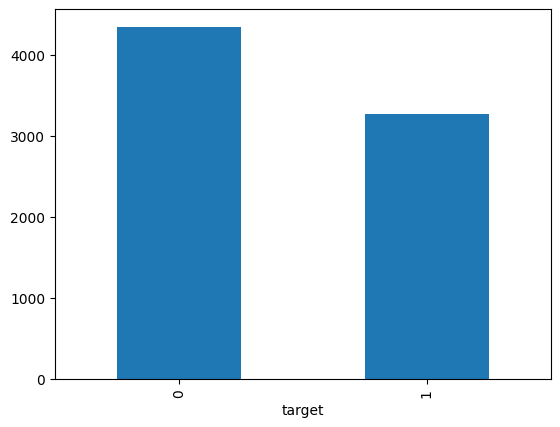

In [20]:
# checking the target distribution
train_df.target.value_counts().plot(kind = 'bar')

We see that there is a balanaced distribution of the target levels.

In [21]:
# checking some of the positive disaster tweets
for i in range(5):
  print(train_df[train_df.target==1]['text'].iloc[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [22]:
# checking some of the neagtive disaster tweets
for i in range(5):
  print(train_df[train_df.target==0]['text'].iloc[i])

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


In [23]:
# Exploring the text lengths
textlen = train_df['text'].apply(lambda x: len(x.split()))

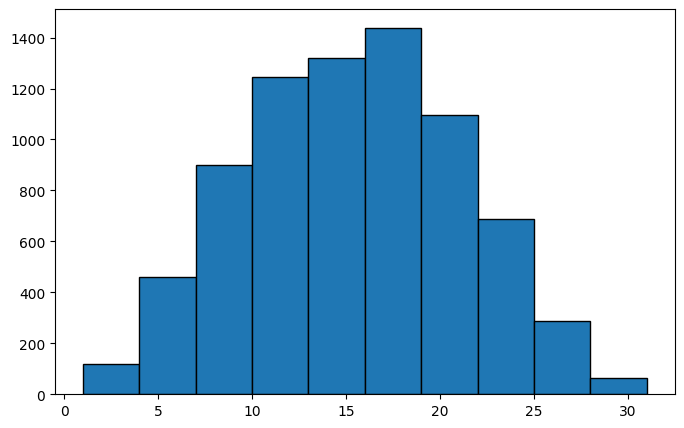

In [24]:
# vsualize the text length
import seaborn as sns
plt.figure(figsize=(8,5))
plt.hist(textlen, edgecolor = "black");

We can set the maximum sequence length as 30, for training our bert model.

In [25]:
SEQ_LEN = 30

### Fine Tuning BERT

In [26]:
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf

In [ ]:
# download the tokenizer
#task = "sentiment"
#MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
#tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case = True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Before tokenizing the text, we can do some text cleaning to remove the user name and any http links in the tweet text.

In [28]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [29]:
train_df['text'] = train_df['text'].apply(preprocess)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


**Encoding the text for Bert model**

In [30]:
# example of tokenization
tokenizer.tokenize(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

In [31]:
# example of an output from encoded text by tokeneizer
encoded_input = tokenizer(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))
print(encoded_input)

{'input_ids': [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [32]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] our deeds are the reason of this earthquake may allah forgive us all [SEP]'

In [33]:
# encoding the training data
train_encoded_inputs = tokenizer(train_df['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')


In [34]:
train_encoded_inputs

{'input_ids': <tf.Tensor: shape=(7613, 30), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  1012, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,  1012,   102,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 30), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

**Creating Tensorflow data**

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['target'].values))

In [36]:
# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}

  return inputs, labels

In [37]:
train_dataset = train_dataset.map(map_bert)

In [38]:
for t in train_dataset.take(2):
  print (t)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,
        2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,
        1012,  2710,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

**Creating train and test split**

In [39]:
dataset = train_dataset.shuffle(100000).batch(64)

In [40]:
# length of the dataset(total batches)
DS_LEN = len(dataset)
DS_LEN

119

In [41]:
# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

**Modeling**

In [42]:
from transformers import TFAutoModel

In [43]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
# create model architecture
#n_classes = len((train_df.target.unique()))

# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 30, 76                                       

In [46]:
# freezing the pretrained bert layer
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 30, 76                                       

**Compile model**

In [47]:
import transformers

In [48]:
#learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [49]:
# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks
)

Epoch 1/50
95/95 [==============================] - 36s 204ms/step - loss: 0.5519 - accuracy: 0.7311 - val_loss: 0.5525 - val_accuracy: 0.7743 - lr: 5.0000e-04
Epoch 2/50
95/95 [==============================] - 16s 167ms/step - loss: 0.4748 - accuracy: 0.7821 - val_loss: 0.4678 - val_accuracy: 0.8239 - lr: 5.0000e-04
Epoch 3/50
95/95 [==============================] - 16s 170ms/step - loss: 0.4507 - accuracy: 0.7961 - val_loss: 0.4187 - val_accuracy: 0.8245 - lr: 5.0000e-04
Epoch 4/50
95/95 [==============================] - 17s 174ms/step - loss: 0.4347 - accuracy: 0.8010 - val_loss: 0.3992 - val_accuracy: 0.8265 - lr: 5.0000e-04
Epoch 5/50
95/95 [==============================] - 16s 172ms/step - loss: 0.4372 - accuracy: 0.7980 - val_loss: 0.3816 - val_accuracy: 0.8369 - lr: 5.0000e-04
Epoch 6/50
95/95 [==============================] - 16s 170ms/step - loss: 0.4160 - accuracy: 0.8253 - val_loss: 0.3521 - val_accuracy: 0.8519 - lr: 5.0000e-04
Epoch 7/50
95/95 [======================

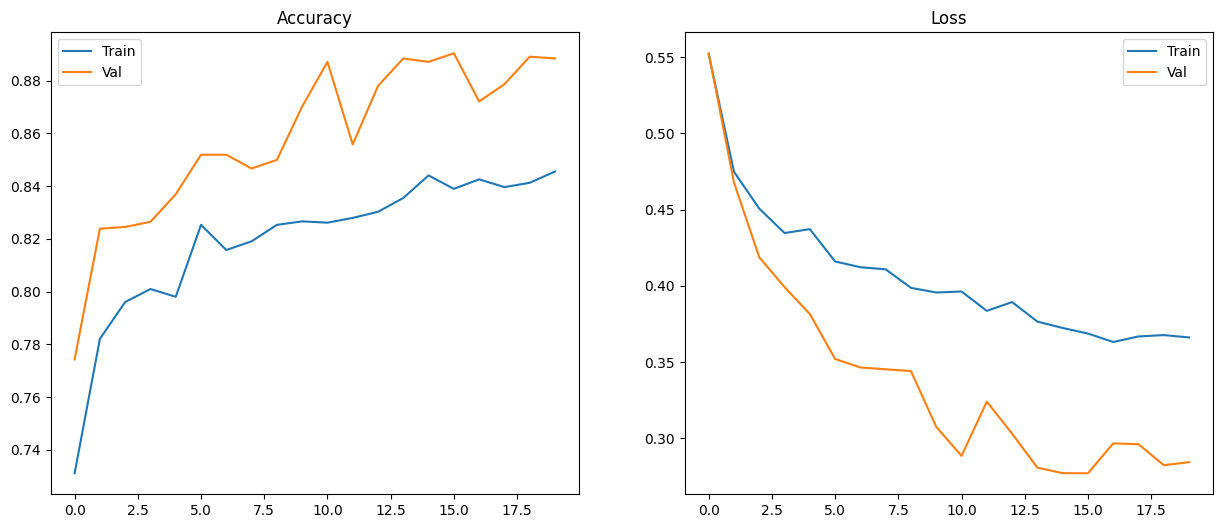

In [50]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1,2, 1)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,2, 2)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [51]:
# evaluate on val data
model.evaluate(val_ds)

24/24 [==============================] - 3s 132ms/step - loss: 0.2770 - accuracy: 0.8878


[0.27704015374183655, 0.8878017067909241]

### Make prediction for test data

In [52]:
test_df = pd.read_csv('test.csv')

In [53]:
# clean text
test_df['text'] = test_df['text'].apply(preprocess)

In [54]:
# encoding the test data
test_encoded_inputs = tokenizer(test_df['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [55]:
# create tf dataset
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))


In [56]:
test_dataset

<_TensorSliceDataset element_spec={'input_ids': TensorSpec(shape=(30,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(30,), dtype=tf.int32, name=None)}>

In [57]:
for d in train_dataset.take(1):
  print (d)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,
        2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [58]:
# make prediction
test_ds = test_dataset.shuffle(100000).batch(64)
test_pred = model.predict(test_ds)

51/51 [==============================] - 9s 130ms/step


In [59]:
test_pred

array([[0.24048439],
       [0.4040819 ],
       [0.44900164],
       ...,
       [0.54793924],
       [0.31726542],
       [0.24703884]], dtype=float32)

In [60]:
test_pred.shape

(3263, 1)

In [61]:
# create the target labels for test data
test_target = np.round(test_pred).flatten()
test_target

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [62]:
test_target.shape

(3263,)

In [63]:
test_df['target'] = test_target.astype('int')
test_df.head(6)

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,0
1,2,NaN,NaN,"heard about earthquake is different cities, st...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,apocalypse lighting. spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,0
5,12,NaN,NaN,we're shaking...it's an earthquake,1


In [64]:
test_df.tail(6)

,id,keyword,location,text,target
3257,10858,NaN,NaN,the death toll in a is-suicide car bombing on ...,0
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...,0
3259,10865,NaN,NaN,storm in ri worse than last hurricane. my city...,0
3260,10868,NaN,NaN,green line derailment in chicago,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook (hwo),0
3262,10875,NaN,NaN,cityofcalgary has activated its municipal emer...,0
